In [66]:
import warnings
warnings.filterwarnings("ignore")

In [67]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
from toolz.curried import *
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
from util import *

In [69]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch
from torch.utils.data import DataLoader

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE
from dataloader import subset_sampler

In [70]:
from models import RNN

In [71]:
### Loading saved model
device = torch.device("cuda:0")
best_model_path="/home_nfs/jiangyue/github/carpark-prediction/lightning_logs/version_69/checkpoints/epoch=2-step=1499.ckpt"
# best_model_path="/home_nfs/jiangyue/github/carpark-prediction/lightning_logs/version_43/checkpoints/epoch=18-step=2241.ckpt"
best_model = RNN.load_from_checkpoint(best_model_path).to(device)
print(best_model_path)
print(best_model.device)

/home_nfs/jiangyue/github/carpark-prediction/lightning_logs/version_69/checkpoints/epoch=2-step=1499.ckpt
cuda:0


In [72]:
### Loading saved data
df = pd.read_csv('carpark_data_06_01-21')
df.head()

,sid,tid,AvailableLots,date,min,Weekday,Agency
0,0,0,2797.0,2021-06-01 00:00:00,0,1,0
1,0,1,2797.0,2021-06-01 00:01:00,0,1,0
2,0,2,2797.0,2021-06-01 00:02:00,0,1,0
3,0,3,2797.0,2021-06-01 00:03:00,0,1,0
4,0,4,2797.0,2021-06-01 00:04:00,0,1,0


In [73]:
### Formatting data
df['min']=df['min'].astype(str) 
df['Weekday']=df['Weekday'].astype(str) 
df['Agency']=df['Agency'].astype(str) 
dp = df[df.tid%5==0]
dp.loc[:, 'tid'] = dp['tid']//5
dp.head()
carpark_data_uni = dp
carpark_data_HDB = dp[dp.Agency == '1']
carpark_data_non_HDB = dp[dp.Agency != '1']

In [74]:
dp.head()

,sid,tid,AvailableLots,date,min,Weekday,Agency
0,0,0,2797.0,2021-06-01 00:00:00,0,1,0
5,0,1,2799.0,2021-06-01 00:05:00,1,1,0
10,0,2,2803.0,2021-06-01 00:10:00,2,1,0
15,0,3,2805.0,2021-06-01 00:15:00,3,1,0
20,0,4,2804.0,2021-06-01 00:20:00,4,1,0


In [75]:
time_step = 100 ### 100*5mins = 500 mins = 8:20 in the morning
day_step = 1 ### The second day
T = time_step+288*day_step ### Setting the time as the prediction starting time(should longer than 12 hours total)
carpark_data_T = carpark_data_uni[carpark_data_uni.tid<=T]

In [76]:
carpark_data_T = carpark_data_T[(carpark_data_T.tid>= T-289)& (carpark_data_T.tid<=T)]
carpark_data_T['tid']= carpark_data_T['tid'].map(lambda x: x-T+289)

In [77]:
### Create filling window
tid_start=len(carpark_data_T.tid.unique())

tid_end=tid_start+23
sid_start=0
sid_end=len(carpark_data_T.sid.unique())-1
date_info=carpark_data_T.iloc[tid_start-1].at['date']
carpark_data_c=carpark_data_T.copy()

date_data=pd.date_range(date_info, periods=25, freq='5T')[1:]
sid_list=range(len(carpark_data_T.sid.unique()))

In [78]:
# carpark_data_T[carpark_data_T.sid ==0].Agency[0]
# carpark_data_T[(carpark_data_T.sid ==0) & (carpark_data_T.tid == T)].Weekday.values

In [79]:
for x in carpark_data_T.sid.unique():
    data={"sid":[x]*24,"tid":range(tid_start, tid_end+1),"AvailableLots":[0]*24, 'date':date_data, 'Weekday': carpark_data_T[(carpark_data_T.sid ==x) & (carpark_data_T.tid == 289)].Weekday.values, 'Agency': carpark_data_T[(carpark_data_T.sid ==x) & (carpark_data_T.tid == 289)].Agency.values}
    df=pd.DataFrame(data,index=range(24))
    df["min"] = (df.tid % 288).astype(str)
    frames = [carpark_data_c, df]
    carpark_data_c = pd.concat(frames)

In [80]:
carpark_data_c=carpark_data_c.reset_index(drop=True)

In [81]:
carpark_data_c[carpark_data_c.sid == 0 ]

,sid,tid,AvailableLots,date,min,Weekday,Agency
0,0,0,1542.0,2021-06-01 08:15:00,99,1,0
1,0,1,1537.0,2021-06-01 08:20:00,100,1,0
2,0,2,1530.0,2021-06-01 08:25:00,101,1,0
3,0,3,1533.0,2021-06-01 08:30:00,102,1,0
4,0,4,1536.0,2021-06-01 08:35:00,103,1,0
...,...,...,...,...,...,...,...
534489,0,309,0.0,2021-06-02 10:00:00,21,2,0
534490,0,310,0.0,2021-06-02 10:05:00,22,2,0
534491,0,311,0.0,2021-06-02 10:10:00,23,2,0
534492,0,312,0.0,2021-06-02 10:15:00,24,2,0


In [82]:
print(carpark_data_c[carpark_data_c.tid==0])

         sid  tid  AvailableLots                 date min Weekday Agency
0          0    0         1542.0  2021-06-01 08:15:00  99       1      0
290        1    0         1855.0  2021-06-01 08:15:00  99       1      0
580        2    0          705.0  2021-06-01 08:15:00  99       1      0
870        3    0         1201.0  2021-06-01 08:15:00  99       1      0
1160       4    0          140.0  2021-06-01 08:15:00  99       1      0
...      ...  ...            ...                  ...  ..     ...    ...
533020  1913    0           90.0  2021-06-01 08:15:00  99       1      1
533310  1914    0          220.0  2021-06-01 08:15:00  99       1      1
533600  1915    0          150.0  2021-06-01 08:15:00  99       1      1
533890  1916    0           81.0  2021-06-01 08:15:00  99       1      0
534180  1917    0          481.0  2021-06-01 08:15:00  99       1      0

[1843 rows x 7 columns]


In [83]:
context_length = 12*12
prediction_length = 2*12

test = TimeSeriesDataSet(
    carpark_data_c,
    time_idx="tid",
    group_ids=["sid"],
    target="AvailableLots",
    time_varying_unknown_reals=["AvailableLots"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    static_categoricals = ["Agency"],
    time_varying_known_categoricals=["min", "Weekday"],
    allow_missings=True,
    predict_mode=True
)

In [84]:
real_prediction=best_model.predict(test, batch_size=500, show_progress_bar=True)

Predict:   0%|          | 0/4 [00:00<?, ? batches/s]

In [85]:
len(carpark_data_uni.sid.unique())

1843

In [86]:
# Predict the carpark lots using form [ID, 0 min : 30 mins]
# Here predicting carpark ID = 523 for future 30 minutes
carparkid = 523
real_prediction[carparkid,0:6]

tensor([332.9641, 334.4426, 335.1032, 334.7794, 335.4297, 334.9039])

In [87]:
carparkid = carpark_data_uni.sid.unique()[carparkid]

In [88]:
carpark_data_uni[(carpark_data_uni.sid == carparkid) & (carpark_data_uni.tid <=T +6) & (carpark_data_uni.tid>= T)] 

,sid,tid,AvailableLots,date,min,Weekday,Agency
15817460,537,388,334.0,2021-06-02 08:20:00,100,2,1
15817465,537,389,334.0,2021-06-02 08:25:00,101,2,1
15817470,537,390,334.0,2021-06-02 08:30:00,102,2,1
15817475,537,391,334.0,2021-06-02 08:35:00,103,2,1
15817480,537,392,334.0,2021-06-02 08:40:00,104,2,1
15817485,537,393,334.0,2021-06-02 08:45:00,105,2,1
15817490,537,394,340.0,2021-06-02 08:50:00,106,2,1


In [89]:
### Calculating carpark maximum valume
maxlots = carpark_data_uni['AvailableLots'].groupby(carpark_data_uni['sid'])
carpark_data_uni = pd.merge(carpark_data_uni, maxlots.max(), how = 'left', on = 'sid')
carpark_data_uni.rename(columns = {"AvailableLots_x": "AvailableLots", "AvailableLots_y": "MaxLots"}, inplace = True)
carpark_data_uni['Difficulty'] = carpark_data_uni.AvailableLots/carpark_data_uni.MaxLots//0.15

In [90]:
carpark_data_uni['Difficulty'] = carpark_data_uni.Difficulty.map(lambda x: 2 if x >=2 else x)
carpark_data_uni['Difficulty'] = carpark_data_uni.Difficulty.map(lambda x: 0 if x <0 else x)
carpark_data_uni.head()

,sid,tid,AvailableLots,date,min,Weekday,Agency,MaxLots,Difficulty
0,0,0,2797.0,2021-06-01 00:00:00,0,1,0,2849.0,2.0
1,0,1,2799.0,2021-06-01 00:05:00,1,1,0,2849.0,2.0
2,0,2,2803.0,2021-06-01 00:10:00,2,1,0,2849.0,2.0
3,0,3,2805.0,2021-06-01 00:15:00,3,1,0,2849.0,2.0
4,0,4,2804.0,2021-06-01 00:20:00,4,1,0,2849.0,2.0


In [91]:
carpark_data_uni[(carpark_data_uni.sid == carparkid) & (carpark_data_uni.tid <=T +6) & (carpark_data_uni.tid>= T)] 

,sid,tid,AvailableLots,date,min,Weekday,Agency,MaxLots,Difficulty
3163492,537,388,334.0,2021-06-02 08:20:00,100,2,1,371.0,2.0
3163493,537,389,334.0,2021-06-02 08:25:00,101,2,1,371.0,2.0
3163494,537,390,334.0,2021-06-02 08:30:00,102,2,1,371.0,2.0
3163495,537,391,334.0,2021-06-02 08:35:00,103,2,1,371.0,2.0
3163496,537,392,334.0,2021-06-02 08:40:00,104,2,1,371.0,2.0
3163497,537,393,334.0,2021-06-02 08:45:00,105,2,1,371.0,2.0
3163498,537,394,340.0,2021-06-02 08:50:00,106,2,1,371.0,2.0


In [92]:
### True parking difficulty
df_o = carpark_data_uni[(carpark_data_uni.tid <=T +6) & (carpark_data_uni.tid>= T)] 
True_diffi = []
for x in carpark_data_uni.sid.unique():
    a = df_o[(df_o.tid==T+6)&(df_o.sid ==x)].Difficulty.values
    True_diffi.append(a)

print(len(True_diffi))

1843


In [93]:
### Predicted parking difficulty
pred_30 = real_prediction[:,6]
pred_30_diffi = pred_30/maxlots.max()//0.15
a = pred_30_diffi.map(lambda x: 2 if x >=2 else x)
b = a.map(lambda x: 0 if x <0 else x)
pred_30_diffi = []
for x in carpark_data_uni.sid.unique():
    pred_30_diffi.append(b[x])

In [94]:
Correct = 0
for x in range(len(pred_30_diffi)):
    if pred_30_diffi[x] == True_diffi[x]:
        Correct += 1
print(Correct, 'out of ', len(pred_30_diffi), 'parking lots predicted correct, precision rate is ', Correct/len(pred_30_diffi)*100, '%')

1759 out of  1843 parking lots predicted correct, precision rate is  95.44221378187737 %


In [95]:
# carpark_data_uni=carpark_data_uni.drop(['MaxLots','Difficulty'], axis=1)

<AxesSubplot:xlabel='date'>

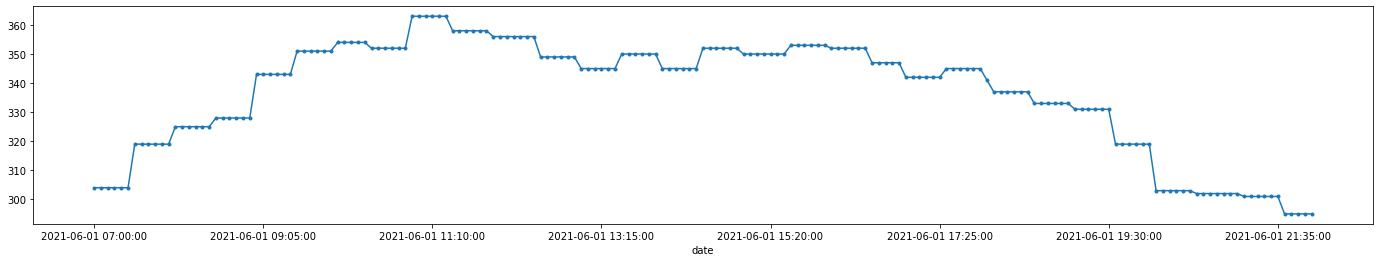

In [96]:
# xs = pd.date_range("2021-06-01", periods=13)
carpark_data_plot = carpark_data_uni[(carpark_data_uni.tid>=84)& (carpark_data_uni.tid <=264)]
ts = carpark_data_plot[carpark_data_plot.sid == carparkid].set_index("date")["AvailableLots"]
ts.plot(figsize=(24, 4), style=".-")
# for x in xs:
#     plt.axvline(x=x, linestyle='--', color="m")